In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
sales = pd.read_csv("C:\\Users\\DHRUBAJIT\\Desktop\\AnalyticsVidhya\\Big Mart Sales\\Big_Mart_Sales_train.csv")

for i in sales.Item_Type.unique():
    group1 = sales[sales['Item_Type'] == i]
    ave = group1['Item_Weight'].mean()
    group1['Item_Weight'] = group1['Item_Weight'].fillna(ave)
   
    sales.loc[sales['Item_Weight'].isnull(),'Item_Weight'] = group1['Item_Weight']
    
    
outlet_size_mode = sales['Outlet_Size'].mode()[0]
sales['Outlet_Size'] = sales['Outlet_Size'].fillna(outlet_size_mode)

sales['Item_Visibility'] = np.sqrt(sales['Item_Visibility'])

sales['Item_MRP'] = np.sqrt(sales['Item_MRP'])

sales['Item_Outlet_Sales'] = np.sqrt(sales['Item_Outlet_Sales'])

sales = sales.replace({'Item_Fat_Content' : { 'low fat' : 'Low Fat', 'LF' : 'Low Fat', 'reg' : 'Regular' }})
fat_content = {'Low Fat':0,'Regular':1}
sales['Item_Fat_Content'] = sales['Item_Fat_Content'].map(fat_content)

out_size = {'Small':0,'Medium':1, 'High':2}
sales['Outlet_Size'] = sales['Outlet_Size'].map(out_size)

out_loctype = {'Tier 1':0,'Tier 2':1, 'Tier 3':2}
sales['Outlet_Location_Type'] = sales['Outlet_Location_Type'].map(out_loctype)

out_type = {'Grocery Store':0,'Supermarket Type1':1, 'Supermarket Type2':2, 'Supermarket Type3':3}
sales['Outlet_Type'] = sales['Outlet_Type'].map(out_type)

i_type = {'Dairy':0, 'Soft Drinks':1, 'Meat':2, 'Fruits and Vegetables':3,
       'Household':4, 'Baking Goods':5, 'Snack Foods':6, 'Frozen Foods':7,
       'Breakfast':8, 'Health and Hygiene':9, 'Hard Drinks':10, 'Canned':11,
       'Breads':12, 'Starchy Foods':13, 'Seafood':14,'Others':15}
sales['Item_Type'] = sales['Item_Type'].map(i_type)

sales.head()

C:\Users\DHRUBAJIT\Anaconda3\lib\site-packages\ipykernel\__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,0,0.126678,0,15.805354,OUT049,1999,1,0,1,61.115775
1,DRC01,5.92,1,0.138846,1,6.947604,OUT018,2009,1,2,2,21.057607
2,FDN15,17.50,0,0.129461,2,11.900336,OUT049,1999,1,0,1,45.795961
3,FDX07,19.20,1,0.000000,3,13.494258,OUT010,1998,1,2,0,27.062520
4,NCD19,8.93,0,0.000000,4,7.339033,OUT013,1987,2,2,1,31.538947


In [3]:
X = sales.drop(['Item_Identifier','Outlet_Identifier','Item_Outlet_Sales'], axis=1)
y = sales.Item_Outlet_Sales

In [4]:
from sklearn.model_selection import train_test_split
xtrain,xtest,ytrain,ytest = train_test_split(X,y, random_state=0, test_size=0.3)

### Trial 1

In [6]:
# Default Random Forest
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
rf = RandomForestRegressor()
rf.fit(xtrain, ytrain)
rf_pred = rf.predict(xtest)
print(rf.score(xtrain,ytrain))
print(rf.score(xtest,ytest))
print(np.sqrt(mean_squared_error(ytest,rf_pred)))

0.928409864018
0.607356131157
11.7191687226


RandomForest is overfitting the data.

Lets tune the model.

In [13]:
tuned_param = {'min_samples_leaf': [1,5,10,50,100,200,500], 'n_estimators' : range(100,1000,100),
                    'max_features':['auto','sqrt','log2']}

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
RR_model= RandomizedSearchCV(rf, tuned_param,cv=10,n_iter=20,n_jobs= -1)
RR_model.fit(xtrain,ytrain)
print(RR_model.best_score_)
print(RR_model.best_params_)

0.672390075512
{'n_estimators': 300, 'max_features': 'auto', 'min_samples_leaf': 50}


In [14]:
RR_pred = RR_model.predict(xtest)
print(RR_model.score(xtrain,ytrain))
print(RR_model.score(xtest,ytest))
print(np.sqrt(mean_squared_error(ytest,RR_pred)))

0.699262794247
0.665293797164
10.8200502369


### Trial 2 

In [15]:
# applying PCA
from sklearn.decomposition import PCA
pca = PCA()
pca.fit_transform(X)
print(pca.explained_variance_ratio_)

[  6.30347725e-01   1.61750696e-01   1.22442686e-01   6.86851592e-02
   9.38733497e-03   3.86245526e-03   2.04776482e-03   1.37656594e-03
   9.96119638e-05]


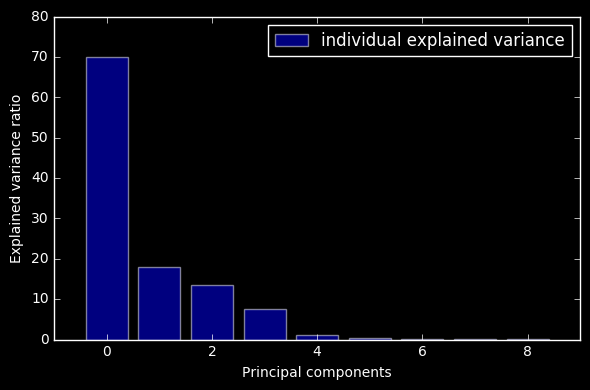

In [20]:
with plt.style.context('dark_background'):
    plt.figure(figsize=(6, 4))
    
    plt.bar(range(9), pca.explained_variance_, alpha=0.5, align='center',
            label='individual explained variance')
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal components')
    plt.legend(loc='best')
    plt.tight_layout()

The 1st 5 components retains more than 95% of the data.

In [26]:
# Taking PCA with 5 components
pca_modified = PCA(n_components=5)
pca_modified.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=0)
rf_pca = RandomForestRegressor()
rf_pca.fit(X_train,y_train)
rf_pca_pred = rf_pca.predict(X_test)
print(rf_pca.score(X_train,y_train))
print(rf_pca.score(X_test,y_test))
print(np.sqrt(mean_squared_error(y_test,rf_pca_pred)))

0.934224125316
0.604286231561
11.7648928846


In [30]:
#Tuning the model
X_copy = pca_modified.fit_transform(X)
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_copy,y,test_size=0.3,random_state=0)
tuned_param1 = {'min_samples_leaf': [1,5,10,50,100,200,500], 'n_estimators' : range(100,1000,100),
                    'max_features':['auto','sqrt','log2']}

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
RR_model1= RandomizedSearchCV(rf_pca, tuned_param1,cv=10,n_iter=20,n_jobs= -1)
RR_model1.fit(X_train1,y_train1)
print(RR_model1.best_score_)
print(RR_model1.best_params_)

0.657343068274
{'n_estimators': 500, 'max_features': 'log2', 'min_samples_leaf': 5}


In [32]:
RR_pred1 = RR_model1.predict(X_test1)
print(RR_model1.score(X_train1,y_train1))
print(RR_model1.score(X_test1,y_test1))
print(np.sqrt(mean_squared_error(y_test1,RR_pred1)))

0.814499278251
0.658296978866
10.9325584023


### Trial 3

In [34]:
# taking KernelPCA
from sklearn.decomposition import KernelPCA
kpca = KernelPCA(kernel='rbf', n_components=5)
kpca.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=0)
rf_kpca = RandomForestRegressor()
rf_kpca.fit(X_train,y_train)
rf_kpca_pred = rf_kpca.predict(X_test)
print(rf_kpca.score(X_train,y_train))
print(rf_kpca.score(X_test,y_test))
print(np.sqrt(mean_squared_error(y_test,rf_kpca_pred)))

0.932710403323
0.60693223899
11.7254929316


In [38]:
# tuning the model
X_copy2 = kpca.fit_transform(X)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_copy2,y,test_size=0.3,random_state=0)
tuned_param2 = {'min_samples_leaf': [1,5,10,50,100,200,500], 'n_estimators' : range(100,1000,100),
                    'max_features':['auto','sqrt','log2']}

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
RR_model2= RandomizedSearchCV(rf_kpca, tuned_param2,cv=10,n_iter=20,n_jobs= -1)
RR_model2.fit(X_train2,y_train2)
print(RR_model2.best_score_)
print(RR_model2.best_params_)

0.301603671819
{'n_estimators': 800, 'max_features': 'log2', 'min_samples_leaf': 10}


In [39]:
RR_pred2 = RR_model2.predict(X_test2)
print(RR_model2.score(X_train2,y_train2))
print(RR_model2.score(X_test2,y_test2))
print(np.sqrt(mean_squared_error(y_test2,RR_pred2)))

0.504538069394
0.328492676532
15.3257865801


### Trial 4

In [50]:
# Using statsmodels to select features: Backward Elimination
import statsmodels.formula.api as sn
X = np.append(arr = np.ones((8523,1)).astype(int), values = X, axis=1)
X_opt = X[:,[0,1,2,3,4,5,6,7,8,9]]
model = sn.OLS(endog = y, exog = X_opt).fit()
print(model.summary()) 

                            OLS Regression Results                            
Dep. Variable:      Item_Outlet_Sales   R-squared:                       0.341
Model:                            OLS   Adj. R-squared:                  0.340
Method:                 Least Squares   F-statistic:                     879.6
Date:                Wed, 26 Apr 2017   Prob (F-statistic):               0.00
Time:                        14:06:12   Log-Likelihood:                -35122.
No. Observations:                8523   AIC:                         7.026e+04
Df Residuals:                    8517   BIC:                         7.030e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          0.8248      0.193      4.283      0.0

In [51]:
X_opt = X[:,[0,1,2,3,4,6,7,8,9]]
model = sn.OLS(endog = y, exog = X_opt).fit()
print(model.summary()) 

                            OLS Regression Results                            
Dep. Variable:      Item_Outlet_Sales   R-squared:                       0.341
Model:                            OLS   Adj. R-squared:                  0.340
Method:                 Least Squares   F-statistic:                     1100.
Date:                Wed, 26 Apr 2017   Prob (F-statistic):               0.00
Time:                        14:07:56   Log-Likelihood:                -35122.
No. Observations:                8523   AIC:                         7.025e+04
Df Residuals:                    8518   BIC:                         7.029e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const        6.07e+11   2.75e+12      0.220      0.8

In [59]:
X_opt = X[:,[0,6,7,8,9]]
model = sn.OLS(endog = y, exog = X_opt).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:      Item_Outlet_Sales   R-squared:                       0.341
Model:                            OLS   Adj. R-squared:                  0.340
Method:                 Least Squares   F-statistic:                     1100.
Date:                Wed, 26 Apr 2017   Prob (F-statistic):               0.00
Time:                        14:17:13   Log-Likelihood:                -35122.
No. Observations:                8523   AIC:                         7.025e+04
Df Residuals:                    8518   BIC:                         7.029e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          3.9326      0.830      4.739      0.0

In [60]:
X_opt = X[:,[0,6,7,9]]
model = sn.OLS(endog = y, exog = X_opt).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:      Item_Outlet_Sales   R-squared:                       0.340
Model:                            OLS   Adj. R-squared:                  0.340
Method:                 Least Squares   F-statistic:                     1466.
Date:                Wed, 26 Apr 2017   Prob (F-statistic):               0.00
Time:                        14:17:51   Log-Likelihood:                -35123.
No. Observations:                8523   AIC:                         7.025e+04
Df Residuals:                    8519   BIC:                         7.028e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          4.2710      0.783      5.455      0.0

In [61]:
rf_new = RandomForestRegressor()
xtr,xte,ytr,yte = train_test_split(X_opt,y, test_size=0.3, random_state=0)
rf_new.fit(xtr,ytr)
rf_new_pred = rf_new.predict(xte)
print(rf_new.score(xtr,ytr))
print(rf_new.score(xte,yte))
print(np.sqrt(mean_squared_error(yte,rf_new_pred)))

0.871189214802
0.252258076743
16.1723548554


In [63]:
# tuning the model
tuned_param4 = {'min_samples_leaf': [1,5,10,50,100,200,500], 'n_estimators' : range(100,1000,100),
                    'max_features':['auto','sqrt','log2']}

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
RR_model4= RandomizedSearchCV(rf_new, tuned_param4,cv=10,n_iter=20,n_jobs= -1)
RR_model4.fit(xtr,ytr)

RandomizedSearchCV(cv=10, error_score='raise',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False),
          fit_params={}, iid=True, n_iter=20, n_jobs=-1,
          param_distributions={'n_estimators': range(100, 1000, 100), 'max_features': ['auto', 'sqrt', 'log2'], 'min_samples_leaf': [1, 5, 10, 50, 100, 200, 500]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=True, scoring=None, verbose=0)

In [65]:
RR_pred4 = RR_model4.predict(xte)
print(RR_model4.score(xtr,ytr))
print(RR_model4.score(xte,yte))
print(np.sqrt(mean_squared_error(yte,RR_pred4)))

0.405857478204
0.352800795541
15.0458380942


### Trial 5

In [67]:
XX = sales.drop(['Item_Identifier','Outlet_Identifier','Item_Outlet_Sales'], axis=1)

In [73]:
# Apply L1 regularization penalty
from sklearn.linear_model import Lasso
lsso = Lasso(alpha=0.5)
lsso.fit(XX,y)
print(lsso.coef_)

[ -0.00000000e+00   0.00000000e+00  -0.00000000e+00   5.71595127e-03
   3.71565338e+00   1.31717514e-01   2.16401808e+00  -3.36553306e+00
   1.09434818e+01]


In [75]:
XX = XX.drop(['Item_Weight','Item_Fat_Content','Item_Visibility'], axis=1)

,Item_Type,Item_MRP,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
0,0,15.805354,1999,1,0,1
1,1,6.947604,2009,1,2,2
2,2,11.900336,1999,1,0,1
3,3,13.494258,1998,1,2,0
4,4,7.339033,1987,2,2,1


In [76]:
new_rf = RandomForestRegressor()
xtra,xtes,ytra,ytes = train_test_split(XX,y, random_state=0,test_size=0.3)
new_rf.fit(xtra,ytra)
new_rf_pred = new_rf.predict(xtes)
print(new_rf.score(xtra,ytra))
print(new_rf.score(xtes,ytes))
print(np.sqrt(mean_squared_error(yte,new_rf_pred)))

0.928497214924
0.579290266058
12.1307786138


In [77]:
#tuning the model
tuned_param5 = {'min_samples_leaf': [1,5,10,50,100,200,500], 'n_estimators' : range(100,1000,100),
                    'max_features':['auto','sqrt','log2']}

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
RR_model5= RandomizedSearchCV(new_rf, tuned_param5,cv=10,n_iter=20,n_jobs= -1)
RR_model5.fit(xtra,ytra)

RandomizedSearchCV(cv=10, error_score='raise',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False),
          fit_params={}, iid=True, n_iter=20, n_jobs=-1,
          param_distributions={'n_estimators': range(100, 1000, 100), 'max_features': ['auto', 'sqrt', 'log2'], 'min_samples_leaf': [1, 5, 10, 50, 100, 200, 500]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=True, scoring=None, verbose=0)

In [78]:
RR_pred5 = RR_model5.predict(xtes)
print(RR_model5.score(xtra,ytra))
print(RR_model5.score(xtes,ytes))
print(np.sqrt(mean_squared_error(ytes,RR_pred5)))

0.694183586955
0.667329424282
10.7870971892


### Trial 6

In [82]:
# Combining L1 regularized penalty with PCA
pca_new = PCA()
pca_new.fit_transform(XX)
print(pca_new.explained_variance_ratio_)

[ 0.75328378  0.14708009  0.0821605   0.0112173   0.00461483  0.0016435 ]


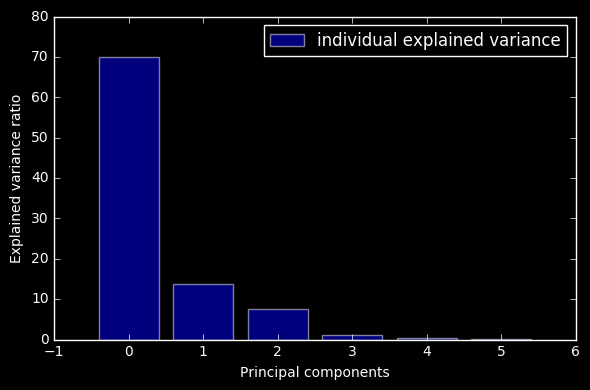

In [83]:
with plt.style.context('dark_background'):
    plt.figure(figsize=(6, 4))
    
    plt.bar(range(6), pca_new.explained_variance_, alpha=0.5, align='center',
            label='individual explained variance')
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal components')
    plt.legend(loc='best')
    plt.tight_layout()

The 1st 3 components retains more than 95% of the data.

In [87]:
# Taking PCA with 5 components
pca_modified1 = PCA(n_components=3)
pca_modified1.fit_transform(XX)
x_train, x_test, yy_train, yy_test = train_test_split(XX,y,test_size=0.3,random_state=0)
rf_pca_lasso = RandomForestRegressor()
rf_pca_lasso.fit(x_train,yy_train)
rf_pca_pred = rf_pca_lasso.predict(x_test)
print(rf_pca_lasso.score(x_train,yy_train))
print(rf_pca_lasso.score(x_test,yy_test))
print(np.sqrt(mean_squared_error(yy_test,rf_pca_pred)))

0.927259280857
0.579572293271
12.1267119344


In [89]:
#Tuning the model
X_co = pca_modified1.fit_transform(XX)
X_train11, X_test11, y_train11, y_test11 = train_test_split(X_co,y,test_size=0.3,random_state=0)
tuned_param1 = {'min_samples_leaf': [1,5,10,50,100,200,500], 'n_estimators' : range(100,1000,100),
                    'max_features':['auto','sqrt','log2']}

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
RR_model11= RandomizedSearchCV(rf_pca, tuned_param1,cv=10,n_iter=20,n_jobs= -1)
RR_model11.fit(X_train11,y_train11)
print(RR_model11.best_score_)
print(RR_model11.best_params_)

0.653169804869
{'n_estimators': 900, 'max_features': 'auto', 'min_samples_leaf': 10}


In [90]:
RR_pred11 = RR_model11.predict(X_test11)
print(RR_model11.score(X_train11,y_train11))
print(RR_model11.score(X_test11,y_test11))
print(np.sqrt(mean_squared_error(y_test11,RR_pred11)))

0.754978556187
0.651285248414
11.0441566125
